In [1]:
from scipy.stats import spearmanr, pearsonr

from bertscore import BERTScore
from conventional_metrics import BLEU, METEOR
from scm import SCM, ContextualSCM, DecontextualizedSCM
from wmd import WMD, ContextualWMD, DecontextualizedWMD
from common import Evaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

if not (Path('embeddings')/'cc.en.300.bin').exists():
    %mkdir -p embeddings
    ! wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O embeddings/cc.en.300.bin.gz
    ! gzip -d embeddings/cc.en.300.bin.gz

### Mutual correlations of metrics

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package wordnet to /home/xnovot32/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xnovot32/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading pack

Evaluating lang pair zh-en


WMD_contextual: construct contextual embeddings:   0%|          | 0/93674 [00:00<?, ?it/s]

WMD_decontextualized: construct decontextualized embeddings:   0%|          | 0/13627 [00:00<?, ?it/s]

WMD_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/13627 [00:00<?, ?it/s]

SCM_decontextualized: construct decontextualized embeddings:   0%|          | 0/13627 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13627/13627 [00:48<00:00, 281.03it/s]


SCM_decontextualized_tfidf: construct decontextualized embeddings:   0%|          | 0/13627 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13627/13627 [00:52<00:00, 258.05it/s]


SCM:   0%|          | 0/46837 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9360/9360 [09:06<00:00, 17.11it/s]


SCM_tfidf:   0%|          | 0/46837 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9360/9360 [08:55<00:00, 17.48it/s]


WMD:   0%|          | 0/46837 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/46837 [00:00<?, ?it/s]

WMD_contextual:   0%|          | 0/46837 [00:00<?, ?it/s]

WMD_decontextualized:   0%|          | 0/46837 [00:00<?, ?it/s]

WMD_decontextualized_tfidf:   0%|          | 0/46837 [00:00<?, ?it/s]

SCM_decontextualized:   0%|          | 0/46837 [00:00<?, ?it/s]

SCM_decontextualized_tfidf:   0%|          | 0/46837 [00:00<?, ?it/s]

BERTScore:   0%|          | 0/1463 [00:00<?, ?it/s]

BLEU:   0%|          | 0/46837 [00:00<?, ?it/s]

METEOR:   0%|          | 0/46837 [00:00<?, ?it/s]

SCM:   0%|          | 0/46837 [00:00<?, ?it/s]

SCM_tfidf:   0%|          | 0/46837 [00:00<?, ?it/s]

WMD:   0%|          | 0/46837 [00:00<?, ?it/s]

WMD_tfidf:   0%|          | 0/46837 [00:00<?, ?it/s]

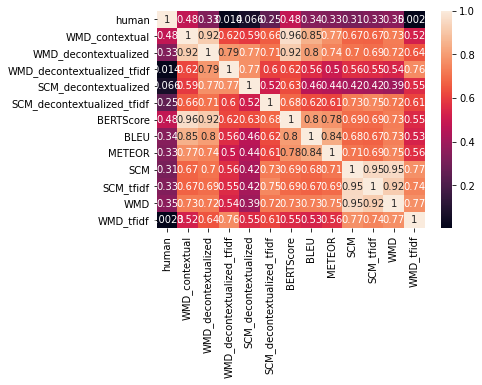

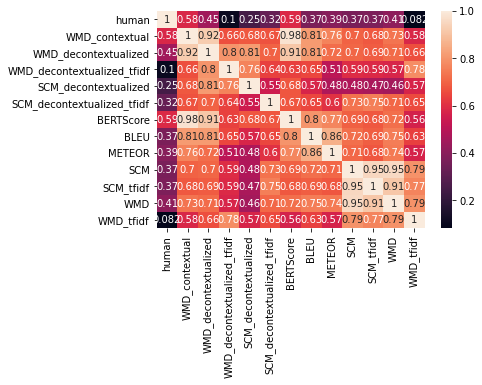

CPU times: user 8h 23min, sys: 14h 7min 58s, total: 22h 30min 59s
Wall time: 59min 28s


In [3]:
%%time

metrics = [
    ContextualWMD(tgt_lang="en"),
    # ContextualSCM(tgt_lang="en"),
    DecontextualizedWMD(tgt_lang="en", use_tfidf=False),
    DecontextualizedWMD(tgt_lang="en", use_tfidf=True),
    DecontextualizedSCM(tgt_lang="en", use_tfidf=False),
    DecontextualizedSCM(tgt_lang="en", use_tfidf=True),
    BERTScore(tgt_lang="en"),
    BLEU(),
    METEOR(),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en", use_tfidf=False),
    WMD(tgt_lang="en", use_tfidf=True),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs_qm

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics, judgements_type="MQM", firstn=None)
    report = evaluator.evaluate()
    reports.append(report)
 
    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]

    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

## Correlations of metrics to Expert Scalar Quality Metrics (eSQM) per language

<AxesSubplot:>

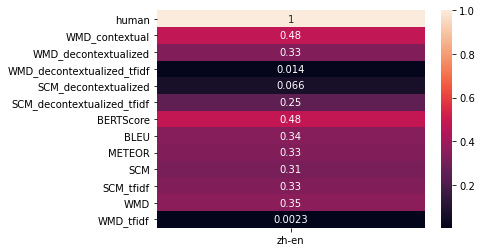

In [4]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

<AxesSubplot:>

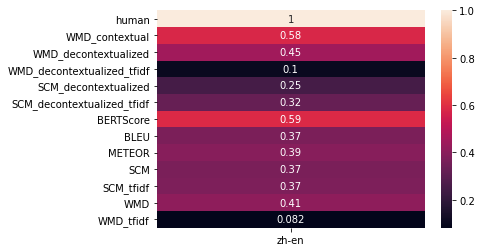

In [5]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)